### import used packages

In [1]:
import pandas as pd
import glob,os
import numpy as np
import pandas as pd 
#import numpy.matlib
import math
#from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
#from scipy.integrate import solve_ivp
import tensorflow as tf
%matplotlib inline

### prepartion

In [2]:
def get_all_time_series():
    path = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    for i in [0,3,4]:
        file = all_files[i]
        df = pd.read_csv(file)
        #confirmed_all = dict()
        if i==0:
            df_confirmed = pd.DataFrame()
            for row in df.values:
                df_confirmed[row[1]] = row[4:]
        if i==3:
            df_recovered = pd.DataFrame()
            for row in df.values:
                df_recovered[row[1]] = row[4:]
        if i==4:
            df_deaths = pd.DataFrame()
            for row in df.values:
                df_deaths[row[1]] = row[4:]
    df_infected = df_confirmed - df_deaths - df_recovered
    return [df_infected,df_confirmed,df_recovered,df_deaths]

[df_infected,df_confirmed,df_recovered,df_deaths] = get_all_time_series()
us_infected = df_infected['US'].values
us_deaths = df_deaths['US'].values
us_recovered = df_recovered['US'].values
us_population = 327200000;
Regr = 70

def solve_SIRD_discrete(num_times,beta_t,gamma_t,mu_t,s0,i0,r0,d0):
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)
    num_times = len(beta_t)

    for i in range(num_times-1):
        Snew = S[i] - beta_t[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta_t[i]/us_population * S[i]*I[i] - gamma_t[i]*I[i] - mu_t[i]*I[i]
        Rnew = R[i] + gamma_t[i]* I[i]
        Dnew = D[i] + mu_t[i]* I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
    return [S,I,R,D]

i0 = us_infected[0]/us_population
r0 = 0
s0 = 1-i0
#R1 = 3./100.
d0 = 0
num_times = len(us_deaths)

#beta=0.26
#gamma=0.08
#mu=0.0033

#beta = 0.275
#gamma = 0.095
#mu = 0.0033

beta = 0.6345301162187955
gamma = 0.43979856466213035
mu = 0.006641658374541129

beta_0 = np.array([beta for i in range(num_times)])
gamma_0 = np.array([gamma for i in range(num_times)])
mu_0 = np.array([mu for i in range(num_times)])


print("beta={}\ngamma={}\nmu={}".format(beta,gamma,mu))

@tf.function()
def tf_loss_fn_us(y_true, y_pred):
    beta_t = y_pred[0][:,0]
    gamma_t = y_pred[0][:,1]
    mu_t = y_pred[0][:,2]
    
    beta_0 = y_true[0][0,0]
    gamma_0 = y_true[0][0,1]
    mu_0 = y_true[0][0,2]
    
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)
    num_times = len(beta_t)

    for i in range(num_times-1):
        Snew = S[i] - beta_t[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta_t[i]/us_population * S[i]*I[i] - gamma_t[i]*I[i] - mu_t[i]*I[i]
        Rnew = R[i] + gamma_t[i]* I[i]
        Dnew = D[i] + mu_t[i]* I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
    I = tf.stack(I)
    D = tf.stack(D)
    epsilon = 0.000001
    sumd1 = (tf.math.log((x_trains[0][:,0]+epsilon))-tf.math.log((I+epsilon)))**2 + (tf.math.log((x_trains[0][:,1]+epsilon))-tf.math.log((D+epsilon)))**2
    Ed1 = tf.math.reduce_sum(sumd1)
    
    Ed2 = 0.01*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/(tf.math.reduce_max(x_trains[0][:,0])+epsilon) * tf.math.reduce_sum((x_trains[0][:,0]-I)**2+ (x_trains[0][:,1]-D)**2)

    sumr = 0
    for it in range(num_times-1):
        sumr = sumr + (beta_t[it]-beta_t[it+1])**2 + (gamma_t[it]-gamma_t[it+1])**2 + 100*(mu_t[it]-mu_t[it+1])**2
    Er = 100*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/tf.math.reduce_max([beta_0,gamma_0,mu_0])*sumr
    
    E0 = 100*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/tf.math.reduce_max([beta_0,gamma_0,mu_0])*((beta_t[0]-beta_0)**2+(gamma_t[0]- gamma_0)**2 +100*(mu_t[0]-mu_0)**2)

    return Ed1+Ed2+Er+E0

beta=0.6345301162187955
gamma=0.43979856466213035
mu=0.006641658374541129


### Regression:  infected

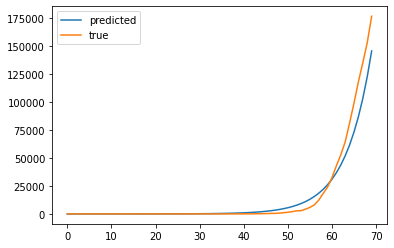

In [3]:
S,I,R,D = solve_SIRD_discrete(num_times,beta_0[0:Regr],gamma_0[0:Regr],mu_0[0:Regr],s0,i0,r0,d0)
plt.plot(np.arange(0,Regr),I , label='predicted')
plt.plot(np.arange(0,Regr),us_infected[0:Regr],label='true')
plt.legend()

### Regression: deaths

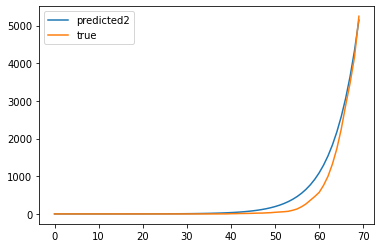

In [4]:
plt.plot(np.arange(0,Regr),D , label='predicted2')
plt.plot(np.arange(0,Regr),us_deaths[0:Regr],label='true')
plt.legend()

### training data

In [5]:
num_times = 82
def to_float(x):
    return float(x)

to_float_vec = np.vectorize(to_float)

x_train = to_float_vec(np.array([us_infected[0:num_times],us_deaths[0:num_times]]).transpose())
num_times = len(x_train)
x_trains = to_float_vec(np.array([x_train]))


num_times = num_times
y_true = np.zeros((num_times,3))
y_true[:,0] = beta_0[0:num_times]
y_true[:,1] = gamma_0[0:num_times]
y_true[:,2] = mu_0[0:num_times]

y_trues = np.array([y_true])

### the model

In [6]:
tf.config.experimental_run_functions_eagerly(False)
model = tf.keras.models.load_model('2020_09_10_fixed82run')

[Sr,Ir,Rr,Dr]= solve_SIRD_discrete(num_times,model.predict(x_trains)[0][:,0],model.predict(x_trains)[0][:,1],model.predict(x_trains)[0][:,2],s0,i0,r0,d0)

### results

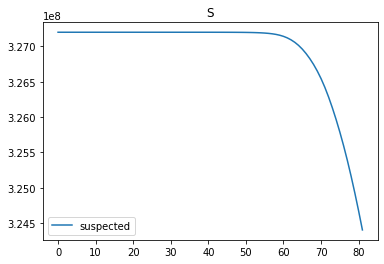

In [17]:
plt.plot(np.arange(num_times),Sr,label="suspected")
plt.legend()
plt.title('S')
plt.savefig('S_82')

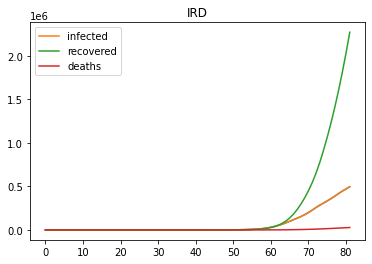

In [16]:
plt.plot(np.arange(num_times),Ir)
plt.plot(np.arange(num_times),Ir,label="infected")
plt.plot(np.arange(num_times),Rr,label="recovered")
plt.plot(np.arange(num_times),Dr,label="deaths")
plt.legend()
plt.title('IRD')
plt.savefig('IRD_82')

### $I_c$ and $\hat{I}$

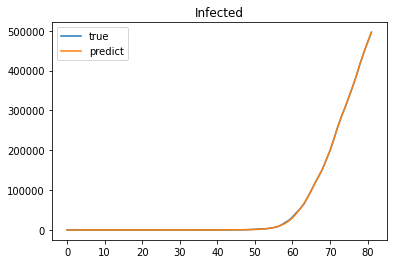

In [9]:
plt.plot(np.arange(0,num_times,1),x_train[:,0],label='true')
plt.plot(np.arange(0,num_times,1),Ir,label='predict')
plt.legend()
plt.title('Infected')
plt.savefig('infected_82')

### $D_c$ and $\hat{D}$

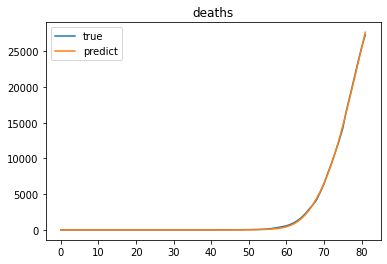

In [10]:
plt.plot(np.arange(0,num_times,1),x_train[:,1],label='true')
plt.plot(np.arange(0,num_times,1),Dr,label='predict')
plt.legend()
plt.title('deaths')
plt.savefig('deaths_82')

### $\beta$, $\gamma$, $\mu$

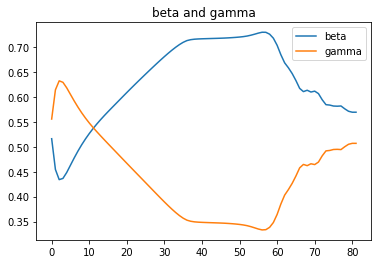

In [11]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,0],label='beta')
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,1],label='gamma')
#plt.plot(np.arange(0,num_times,1),(model.predict(x_trains)[0][:,0]+model.predict(x_trains)[0][:,1])/2,label='gamma')
plt.legend()
plt.title('beta and gamma')
plt.savefig('beta_and_gamma_82')

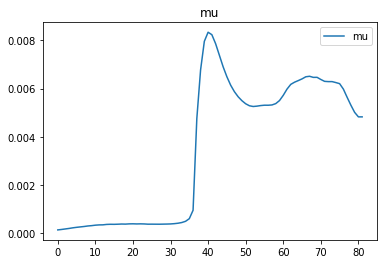

In [12]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,2],label='mu')
plt.legend()
plt.title('mu')
plt.savefig('mu_82')